## Arewa Data Science Academy
### Deep Learning Cohort1.0

#### Name: Abdulrahman Yusuf
#### Email: audura2013@gmail.com
#### Title: Week 3 Solution


## 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [187]:
from sklearn.datasets import make_moons

# Make 1000 samples
n_samples = 1000

# Create moon
X, y = make_moons(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same value

In [188]:
print(f"First 5 X features:\n{X[:3]}")
print(f"\nFirst 5 y labels:\n{y[:3]}")

First 5 X features:
[[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]]

First 5 y labels:
[1 1 1]


In [189]:
# Make DataFrame of moons' data
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head(5)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0


In [190]:
# Check different labels
moons.label.value_counts()

1    500
0    500
Name: label, dtype: int64

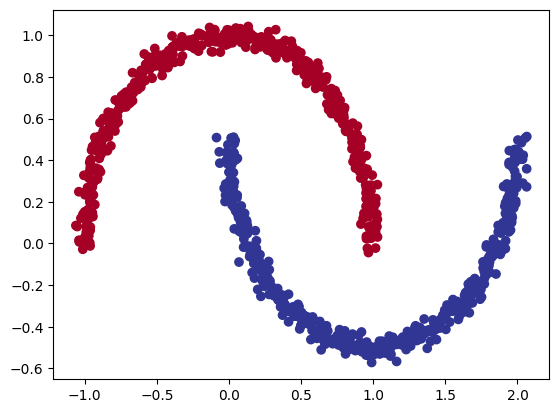

In [191]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [192]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [193]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [-0.00933187  0.39098105] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [194]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [195]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [196]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want

In [197]:
# 1. Construct a model class that subclasses nn.Module
class MoonseModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=12) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=12, out_features=8) # takes in 5 features, produces 1 feature (y)
        self.layer_3 = nn.Linear(in_features=8, out_features=1) # takes in 5 features, produces 1 feature (y)
        self.relu = nn.ReLU()

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_1 = MoonseModelV0().to(device)
model_1

MoonseModelV0(
  (layer_1): Linear(in_features=2, out_features=12, bias=True)
  (layer_2): Linear(in_features=12, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [198]:
# Make predictions with the model
untrained_preds = model_1(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0164],
        [ 0.0042],
        [ 0.0079],
        [-0.0088],
        [ 0.0488],
        [ 0.0590],
        [ 0.0240],
        [ 0.0217],
        [-0.0051],
        [ 0.0020]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [199]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [200]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [201]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[-0.0164],
        [ 0.0042],
        [ 0.0079],
        [-0.0088],
        [ 0.0488]], grad_fn=<SliceBackward0>)

In [202]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4959],
        [0.5011],
        [0.5020],
        [0.4978],
        [0.5122]], grad_fn=<SigmoidBackward0>)

In [203]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 1., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [204]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [205]:
torch.manual_seed(42)

epochs=1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  # print(y_logits[:5]) # model raw outputs are "logits"
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw to desired model outputs
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.68 Acc: 0.60 | Test loss: 0.68 Test acc: 0.57
Epoch: 100 | Loss: 0.36 Acc: 0.85 | Test loss: 0.38 Test acc: 0.81
Epoch: 200 | Loss: 0.23 Acc: 0.89 | Test loss: 0.22 Test acc: 0.92
Epoch: 300 | Loss: 0.17 Acc: 0.92 | Test loss: 0.17 Test acc: 0.93
Epoch: 400 | Loss: 0.13 Acc: 0.95 | Test loss: 0.12 Test acc: 0.95
Epoch: 500 | Loss: 0.08 Acc: 0.98 | Test loss: 0.08 Test acc: 0.99
Epoch: 600 | Loss: 0.05 Acc: 0.99 | Test loss: 0.05 Test acc: 1.00
Epoch: 700 | Loss: 0.03 Acc: 1.00 | Test loss: 0.03 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00


## 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [206]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


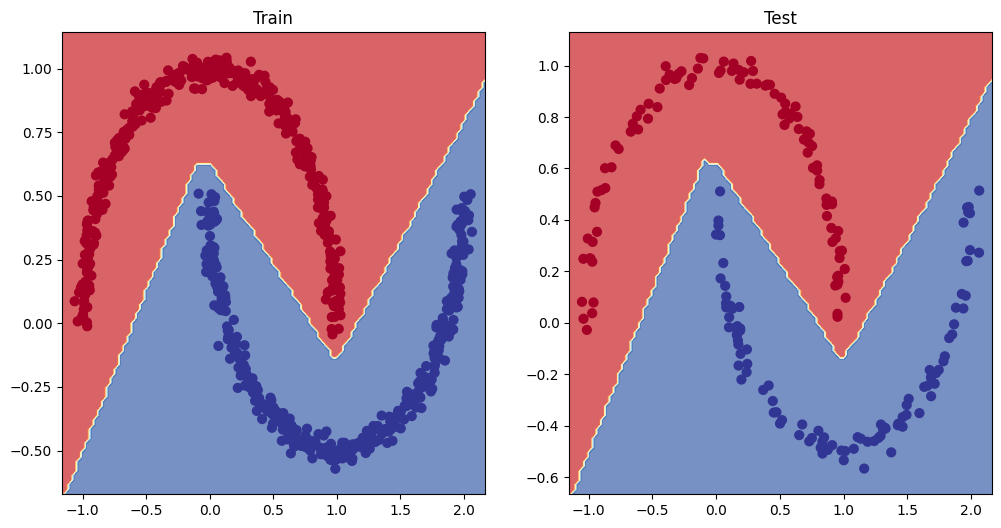

In [207]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
* Feel free to reference the ML cheatsheet website for the formula

In [208]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [209]:
def tanh(z):
	return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))
tanh(A)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
        -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
         1.0000,  1.0000,  1.0000,  1.0000])

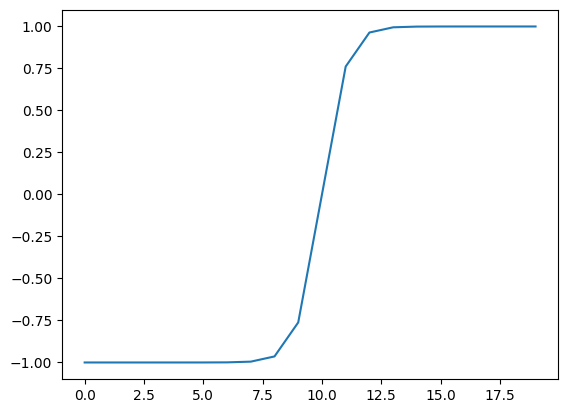

In [210]:
# Plot tanh activated toy tensor
plt.plot(tanh(A));

In [211]:
def tanh_prime(z):
	return 1 - (tanh(z) ** 2)
tanh_prime(A)

tensor([0.0000e+00, 0.0000e+00, 3.5763e-07, 3.0994e-06, 2.4557e-05, 1.8179e-04,
        1.3409e-03, 9.8661e-03, 7.0651e-02, 4.1997e-01, 1.0000e+00, 4.1997e-01,
        7.0651e-02, 9.8661e-03, 1.3409e-03, 1.8179e-04, 2.4557e-05, 3.0994e-06,
        3.5763e-07, 0.0000e+00])

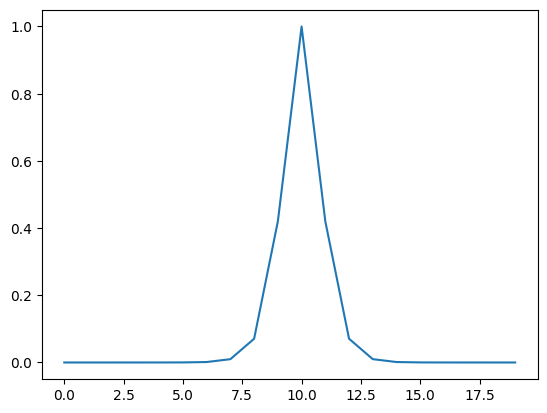

In [212]:
# Plot tanh_prime activated toy tensor
plt.plot(tanh_prime(A));

## 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

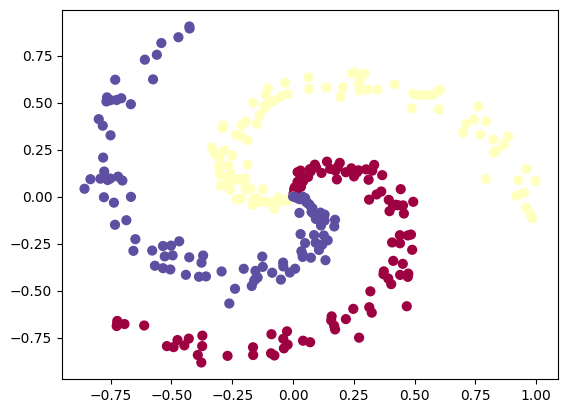

In [213]:
# Code for creating a spiral dataset from CS231n
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [214]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split into train and test sets
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)
len(X_spiral_train), len(X_spiral_test), len(y_spiral_train), len(y_spiral_test)
#X_spiral_train[:8], y_spiral_train[:8]

(240, 60, 240, 60)

In [215]:
# Let's calculate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn


MulticlassAccuracy()

In [216]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

#Create Model
class SpiralModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=12)
    self.linear3 = nn.Linear(in_features=12, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_2 = SpiralModelV0().to(device)
model_2

SpiralModelV0(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=3, bias=True)
  (relu): ReLU()
)

In [217]:
# Setup data to be device agnostic
X_spiral_train, y_spiral_train = X_spiral_train.to(device), y_spiral_train.to(device)
X_spiral_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)
print(X_spiral_train.dtype, X_spiral_test.dtype, y_spiral_train.dtype, y_spiral_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_2(X_train)[:8])

print("Pred probs:")
print(torch.softmax(model_2(X_train)[:8], dim=1))

print("Pred labels:")
print(torch.softmax(model_2(X_train)[:8], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[ 0.0125,  0.0707, -0.2419],
        [ 0.1635,  0.1454, -0.2136],
        [ 0.1495,  0.2003, -0.2188],
        [ 0.1503,  0.1967, -0.2191],
        [ 0.1135,  0.1833, -0.2357],
        [ 0.1558,  0.1862, -0.2192],
        [ 0.0983,  0.1927, -0.2413],
        [ 0.1409,  0.1534, -0.2209]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3527, 0.3738, 0.2735],
        [0.3748, 0.3681, 0.2571],
        [0.3644, 0.3834, 0.2522],
        [0.3651, 0.3825, 0.2524],
        [0.3600, 0.3861, 0.2539],
        [0.3679, 0.3792, 0.2529],
        [0.3557, 0.3910, 0.2533],
        [0.3691, 0.3738, 0.2571]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([1, 0, 1, 1, 1, 1, 1, 1])


In [218]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                             lr=0.02)

In [219]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_2.train()
  # 1. forward pass
  y_logits = model_2(X_spiral_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_spiral_train)
  acc = acc_fn(y_pred, y_spiral_train)


  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_2(X_spiral_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_spiral_test)
    test_acc = acc_fn(test_pred, y_spiral_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.11 Acc: 0.32 | Test loss: 1.12 Test acc: 0.27
Epoch: 100 | Loss: 0.31 Acc: 0.90 | Test loss: 0.32 Test acc: 0.90
Epoch: 200 | Loss: 0.09 Acc: 0.97 | Test loss: 0.09 Test acc: 0.97
Epoch: 300 | Loss: 0.05 Acc: 0.99 | Test loss: 0.04 Test acc: 0.98
Epoch: 400 | Loss: 0.03 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 500 | Loss: 0.03 Acc: 0.99 | Test loss: 0.03 Test acc: 0.98
Epoch: 600 | Loss: 0.02 Acc: 0.99 | Test loss: 0.05 Test acc: 0.98
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.05 Test acc: 0.98
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.06 Test acc: 0.98
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.06 Test acc: 0.98


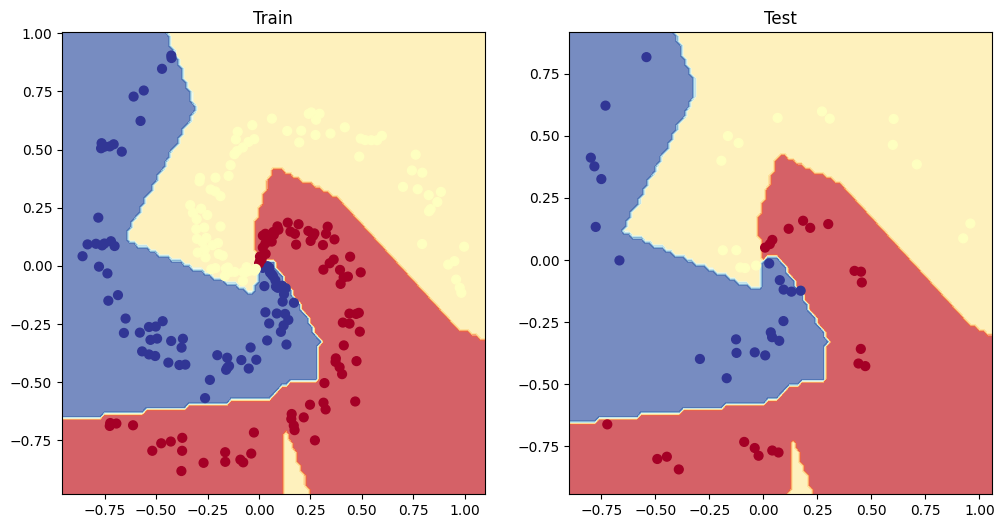

In [220]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_spiral_train, y_spiral_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_spiral_test, y_spiral_test)